In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# importing class object that I created
import sys  
sys.path.insert(0, '../src/')
import utils

In [3]:
tools = utils.tools() # create object

In [4]:
epi_data_df = tools.readfile('../data/processed/epi_vector.h5')
epi_data_df = tools.df

## Data Preparation for Classification

In [5]:
sample_df = epi_data_df.head(10000)
# sample_df
# list(sample_df.columns.values)

In [6]:
# Drop column with all zeros
sample_df = sample_df.loc[:, (sample_df != 0).any(axis=0)]
sample_df.shape

(10000, 7305)

In [7]:
sample_df.head(3)

,""" > panko (japanese bread crumb bread crumb",""" biscuit cutter",""" brown candy "" sugar brown sugar",""" cauliflower floret (cut from 1 large head)",""" cube salt pork",""" large "" egg",""" pie dish",""" piece (about 6 ounce) thick - cut smoke bacon",""" piece ginger, peel, finely grated",""" pita bread",...,zucchini squash,zucchini zucchini,"zucchini, quarter lengthwise then slice across thinly",zucchinis,avg_rating,best_rating,prepare_again_rating,num_reviews,tags,title
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.5,4.0,0.85,25.0,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese"
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.5,4.0,0.67,3.0,"[Ginger, Dessert, Bake, Apple, Almond, Fall, R...","""An Apple a Day"""
http://www.epicurious.com/recipes/food/views/-blanketed-eggplant-305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,4.0,0.75,4.0,"[Tomato, Vegetable, Appetizer, Side, Vegetaria...","""Blanketed"" Eggplant"


In [8]:
# uncomment below lines to replace column with number greater than 0 to 1 to make it binary.
# columns = ['avg_rating','best_rating','worst_rating','prepare_again_rating','num_reviews','total_time', 'tags', 'title']
# df = sample_df.copy()
# for col in sample_df.columns:
#     if col not in columns:
#         df.loc[df[col] > 0, col] = 1
# df.head(25)

In [9]:
# Get count of tags
from collections import Counter
c = Counter()  
sample_df["tags"].apply(lambda x: c.update(x))
pass
# print(c)

In [10]:
# store tag count in df
count = pd.DataFrame()
count['tags_count'] = [c[i] for i in c]
count['tag'] = [i for i in c]
count = count.sort_values(by='tags_count',ascending=False)

# delete row with value < n
indexNames = count[ count['tags_count'] <= 30 ].index
 
# Delete these row indexes from dataFrame
count.drop(indexNames , inplace=True)
count

,tags_count,tag
19,4981,Peanut Free
20,4873,Soy Free
17,4372,Bon Appétit
3,4075,Vegetarian
34,4072,Tree Nut Free
...,...,...
123,31,Veal
212,31,Cookie
539,31,Beef Rib
354,31,New York


In [11]:
# look for ### Free tags
count['allergy_tags'] = count['tag'].str.endswith('Free')

allergy_df = count[count['allergy_tags'] == True]
allergy_df

,tags_count,tag,allergy_tags
19,4981,Peanut Free,True
20,4873,Soy Free,True
34,4072,Tree Nut Free,True
57,2712,Wheat/Gluten-Free,True
33,1590,Dairy Free,True
288,208,Fat Free,True


In [12]:
# Create column in sample_df for allergy tags
for i in allergy_df.tag:
    sample_df[i] = [i in tags for tags in sample_df.tags]

In [13]:
sample_df.head(1)

,""" > panko (japanese bread crumb bread crumb",""" biscuit cutter",""" brown candy "" sugar brown sugar",""" cauliflower floret (cut from 1 large head)",""" cube salt pork",""" large "" egg",""" pie dish",""" piece (about 6 ounce) thick - cut smoke bacon",""" piece ginger, peel, finely grated",""" pita bread",...,prepare_again_rating,num_reviews,tags,title,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.85,25.0,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese",False,False,False,False,False,False


In [14]:
# drop not relevent columns and drop rest of allergy column except one you are analyzing
sample_df = sample_df.drop(columns=['avg_rating','best_rating','prepare_again_rating','num_reviews'],axis=0)

sample_df = sample_df.drop(columns=['Soy Free','Tree Nut Free','Wheat/Gluten-Free','Dairy Free','Fat Free'],axis=0)

sample_df.head(2)

,""" > panko (japanese bread crumb bread crumb",""" biscuit cutter",""" brown candy "" sugar brown sugar",""" cauliflower floret (cut from 1 large head)",""" cube salt pork",""" large "" egg",""" pie dish",""" piece (about 6 ounce) thick - cut smoke bacon",""" piece ginger, peel, finely grated",""" pita bread",...,zucchini blossom,"zucchini blossom, tear into large piece (optional)",zucchini flower,zucchini squash,zucchini zucchini,"zucchini, quarter lengthwise then slice across thinly",zucchinis,tags,title,Peanut Free
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese",False
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[Ginger, Dessert, Bake, Apple, Almond, Fall, R...","""An Apple a Day""",True


In [15]:
# Seperate data and label to classify, 
# X are attribute columns used to classify, Y is the label
# first delete all infinity values in data
sample_df = sample_df[(sample_df != np.inf).all(axis=1)]
X = sample_df.drop(columns=['Peanut Free','tags','title'], axis=1)
Y = sample_df['Peanut Free']
print(Y.head(1))
#X = X.astype('int32') # convert to int if needed
X.head(25)

http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852    False
Name: Peanut Free, dtype: bool


,""" > panko (japanese bread crumb bread crumb",""" biscuit cutter",""" brown candy "" sugar brown sugar",""" cauliflower floret (cut from 1 large head)",""" cube salt pork",""" large "" egg",""" pie dish",""" piece (about 6 ounce) thick - cut smoke bacon",""" piece ginger, peel, finely grated",""" pita bread",...,ziti pasta,zucchini,"zucchini (about 5 medium), slice thin",zucchini blossom,"zucchini blossom, tear into large piece (optional)",zucchini flower,zucchini squash,zucchini zucchini,"zucchini, quarter lengthwise then slice across thinly",zucchinis
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://www.epicurious.com/recipes/food/views/-blanketed-eggplant-305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://www.epicurious.com/recipes/food/views/-bloody-mary-tomato-toast-with-celery-and-horseradish-56389813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://www.epicurious.com/recipes/food/views/-bow-tie-pasta-with-zucchini-101932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://www.epicurious.com/recipes/food/views/-burnt-carrots-and-parsnips-56390131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://www.epicurious.com/recipes/food/views/-california-roll-salad-12246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://www.epicurious.com/recipes/food/views/-candy-corn-frozen-citrus-cream-pops-368770,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://www.epicurious.com/recipes/food/views/-cannoli-ice-cream-sandwiches-242004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://www.epicurious.com/recipes/food/views/-chickpea-barley-and-feta-salad-51239040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# len(sample_df[["Breakfast" in x for x in sample_df.tags]])

In [17]:
from sklearn import preprocessing
# label encoder
le = preprocessing.LabelEncoder()

# Converting string labels into numbers
# Y = le.fit_transform(Y) # 0 ==> False, 1 ==> True
Y


http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852                                           False
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430                                                 True
http://www.epicurious.com/recipes/food/views/-blanketed-eggplant-305                                                 False
http://www.epicurious.com/recipes/food/views/-bloody-mary-tomato-toast-with-celery-and-horseradish-56389813           True
http://www.epicurious.com/recipes/food/views/-bow-tie-pasta-with-zucchini-101932                                      True
                                                                                                                     ...  
http://www.epicurious.com/recipes/food/views/daniel-bouluds-madeleines-51263610                                       True
http://www.epicurious.com/recipes/food/views/daniel-bouluds-short-ribs-braised-in-red-wine-with-celery-duo-106671     True
http://www.epicu

In [18]:
# Uncomment below if need to convert X data into encoder and turn it into tuple list
#X.apply(le.fit_transform)
#X = [tuple(r) for r in X.values.tolist()]

In [19]:
# uncomment below if looking for inf value 
# for col in X.columns:
#     print(X.loc[X[col] > 100000, col])

In [20]:
X1 = X[(X != np.inf).all(axis=1)]

In [21]:
X1.head()

,""" > panko (japanese bread crumb bread crumb",""" biscuit cutter",""" brown candy "" sugar brown sugar",""" cauliflower floret (cut from 1 large head)",""" cube salt pork",""" large "" egg",""" pie dish",""" piece (about 6 ounce) thick - cut smoke bacon",""" piece ginger, peel, finely grated",""" pita bread",...,ziti pasta,zucchini,"zucchini (about 5 medium), slice thin",zucchini blossom,"zucchini blossom, tear into large piece (optional)",zucchini flower,zucchini squash,zucchini zucchini,"zucchini, quarter lengthwise then slice across thinly",zucchinis
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://www.epicurious.com/recipes/food/views/-blanketed-eggplant-305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://www.epicurious.com/recipes/food/views/-bloody-mary-tomato-toast-with-celery-and-horseradish-56389813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://www.epicurious.com/recipes/food/views/-bow-tie-pasta-with-zucchini-101932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Classifier

In [22]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(X.iloc[:10000], Y[:10000]) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [23]:
clf.predict(X.iloc[0:2])

array([False,  True])

In [24]:
from sklearn.naive_bayes import GaussianNB

# # create a guassian classifier
model = GaussianNB()
model.fit(X,Y)
print(model.epsilon_)

7.838258389368502e-06


In [25]:
model.predict(X.iloc[0:2])

array([False,  True])

In [26]:
# I manually took out tags that are not recipe ingredients. And clean input. 
# Uncomment below if  cuisine type is needed

# cuisinetype = pd.read_csv('cuisinetype.txt',header=None)
# cuisinetype = cuisinetype.transpose()
# cuisinetype = np.array(cuisinetype[0])
# cuisinetype = [x.replace('\'','') for x in cuisinetype]
# cuisinetype = [x.replace('[','') for x in cuisinetype]
# cuisinetype = [x.replace(']','') for x in cuisinetype]
# cuisinetype = [x.lstrip() for x in cuisinetype]
# cuisinetype

In [27]:
# Uncomment below if states are needed

# states = pd.read_csv('states.csv',header=None)
# states = states.transpose()
# states = np.array(states[0])
# states = [x.lstrip() for x in states]
# states

In [28]:
# I manually took out cities of USA in the tag list.
# Uncomment below if usa_cuisine is needed

# city = pd.read_csv('usa_city.csv',header=None)
# city = city.transpose()
# city = np.array(city[0])
# city = [x.replace('\'','') for x in city]
# city = [x.replace('[','') for x in city]
# city = [x.replace(']','') for x in city]
# city = [x.lstrip() for x in city]
# usa_cuisine =states+city
# usa_cuisine

In [29]:
# create non_usa_cuisine list

# non_usa_cuisine = []
# for i in cuisinetype:
#     if i not in usa_cuisine:
#         non_usa_cuisine.append(i)


In [30]:
import plotly.express as px
import cufflinks as cf
from  plotly.offline import plot


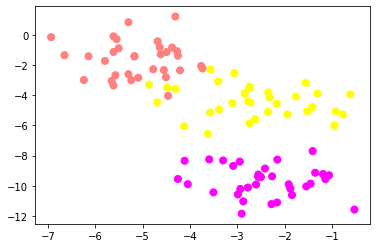

In [31]:
from sklearn.datasets.samples_generator import make_blobs 

x,y = make_blobs(n_samples=100,centers=3,n_features=3)
plt.scatter(x[:, 0], x[:, 1], c=y, s=50, cmap='spring'); 
plt.show()  

from this link: https://www.geeksforgeeks.org/classifying-data-using-support-vector-machinessvms-in-python/